# **CWG(I)FR**算法实现

**参考文献**


[1]伊利亚瑟. (2022). （学习笔记）图像处理——Retinex增强. CSDN. Available at: https://blog.csdn.net/weixin_42985978/article/details/127035841. Accessed: June 27, 2023.

[2] He K , Sun J , Tang X .Guided Image Filtering[J].IEEE Transactions on Pattern Analysis and Machine Intelligence, 2013(6):35.

[3]Li Z,Zheng J,Zhu Z,Yao W. Weighted guided image fil-tering[J]. IEEE Transactionson on Image Processing,2015,24(1):120-128.

[4]Xie S,Lu Y,Yang C. Intensity variation normalization for finger vein recognition using guided filter based singe
scale retinex[J]. Sensors,2015,15:170-191.

[5]陈韵竹,郭剑辉.基于Canny算子加权引导滤波的Retinex医学图像增强算法[J].计算机与数字工程,2019,47(02):407-411+480.

参考以上由SSR->MSR->GIF->GIFR->WGIF->WGIFR->CWGIF->CWGIFR的顺序依次实现。

## **1.SSR**

In [178]:
import cv2
import numpy as np
from numpy import nonzero

def replaceZeroes(data):
    min_nonzero = min(data[nonzero(data)])##data中不为0数字的位置中的最小值
    data[data == 0] = min_nonzero##data中为0的位置换为最小值
    return data

def strench(image):
    MIN = np.min(image)
    MAX = np.max(image)
    #print(MIN,MAX)

    #output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image[i][j] = ((image[i][j]-MIN)/(MAX-MIN)) * 255
    return image

def single_scale_retinex(img, sigma):
    B, G, R = cv2.split(img)
    def channel(C):
        L_C = cv2.GaussianBlur(C, (0, 0), sigma)
        
        C = replaceZeroes(C)
        C = C.astype(np.float32)/255
        L_C = replaceZeroes(L_C)
        L_C = L_C.astype(np.float32)/255
        #C = np.float64(C) + 1.0  # 将图像转换为浮点型，并加上一个小的常数，以避免取对数时出现零值
        dst_C = np.log(C+1.0)
        dst_L_C = np.log(L_C)
        #ret = np.log(C) - np.log(cv2.GaussianBlur(C, (0, 0), sigma).astype(np.float32)/255)  # Retinex公式
        ret = cv2.subtract(dst_C, dst_L_C)
        ret = strench(ret)
        Fret = cv2.convertScaleAbs(ret)
        return Fret
    UB = channel(B)
    UG = channel(G)
    UR = channel(R)
    image = cv2.merge((UB, UG, UR))
    return image

img = cv2.imread('./Fog.png',1)
ret = single_scale_retinex(img,300)


cv2.imshow("SSR",np.concatenate((img,ret),axis=1))
cv2.imshow("SSR.png",ret)
cv2.imwrite("SSR.png",ret)
cv2.waitKey(0)
cv2.destroyAllWindows()

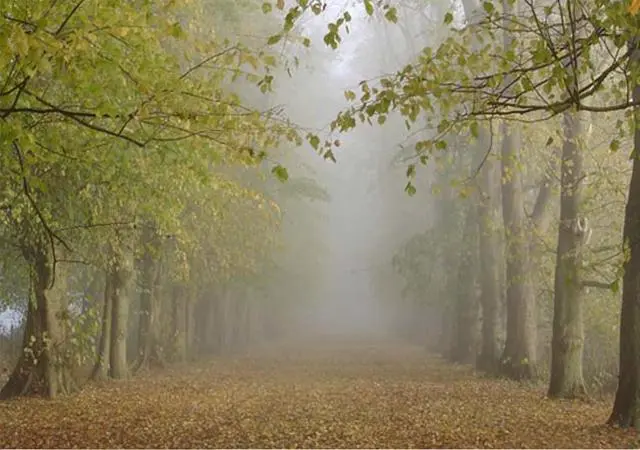

## **2.MSR**

In [40]:
import cv2
import numpy as np
from numpy import nonzero

def replaceZeroes(data):
    min_nonzero = min(data[nonzero(data)])##data中不为0数字的位置中的最小值
    data[data == 0] = min_nonzero##data中为0的位置换为最小值
    return data

def strench(image):
    MIN = np.min(image)
    MAX = np.max(image)
    #print(MIN,MAX)

    #output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image[i][j] = ((image[i][j]-MIN)/(MAX-MIN)) * 255
    return image

def single_scale_retinex(img, sigma):
    B, G, R = cv2.split(img)
    def channel(C):
        L_C = cv2.GaussianBlur(C, (0, 0), sigma)
        
        C = replaceZeroes(C)
        C = C.astype(np.float32)/255
        L_C = replaceZeroes(L_C)
        L_C = L_C.astype(np.float32)/255
        #C = np.float64(C) + 1.0  # 将图像转换为浮点型，并加上一个小的常数，以避免取对数时出现零值
        dst_C = np.log(C)
        dst_L_C = np.log(L_C)
        ret = np.log(C) - np.log(cv2.GaussianBlur(C, (0, 0), sigma).astype(np.float32)/255)  # Retinex公式
        #ret = cv2.subtract(dst_C, dst_L_C)
        ret = strench(ret)
        Fret = cv2.convertScaleAbs(ret)
        return Fret
    UB = channel(B)
    UG = channel(G)
    UR = channel(R)
    image = cv2.merge((UB, UG, UR))
    return image

def multi_scale_retinex(img, sigmalist):
    B, G, R = cv2.split(img)
    weight = 1 / 3.0
    scales_size = 3
    def channel(C,sigmalist):
        for i in range(3):
            
            L_C = cv2.GaussianBlur(C, (0, 0), sigmalist[i])
        
            C = replaceZeroes(C)
            C = C.astype(np.float32)/255
            L_C = replaceZeroes(L_C)
            L_C = L_C.astype(np.float32)/255
            
            ret = np.zeros_like(C)
            #C = np.float64(C) + 1.0  # 将图像转换为浮点型，并加上一个小的常数，以避免取对数时出现零值
            dst_C = np.log(C)
            dst_L_C = np.log(L_C)
            ret += weight * (np.log(C) - np.log(cv2.GaussianBlur(C, (0, 0), sigmalist[i]).astype(np.float32)/255))  # Retinex公式
            #ret = cv2.subtract(dst_C, dst_L_C)
            
        ret = strench(ret)
        Fret = cv2.convertScaleAbs(ret)
        return Fret
    UB = channel(B,sigmalist)
    UG = channel(G,sigmalist)
    UR = channel(R,sigmalist)
    image = cv2.merge((UB, UG, UR))
    return image

img = cv2.imread('./Fog.png',1)
ret = multi_scale_retinex(img,[15,80,250])

#expret = np.exp(ret)


cv2.imshow("MSR",np.concatenate((img,ret),axis=1))
cv2.imshow("MSR.png",ret)
cv2.imwrite("MSR.png",ret)
cv2.waitKey(0)
cv2.destroyAllWindows()

图片同“SSR”

## **3.GIFR**

### **GIF**

In [144]:
def guided_filter(in_image, guide_image, radius, epsilon):
    # 将输入图像和引导图像转换为浮点数类型
    in_image = in_image.astype(np.float64)/255
    guide_image = guide_image.astype(np.float64)/255
    
    ones=np.ones_like(guide_image)
    N = cv2.boxFilter(ones,-1, (radius, radius)); 
    # 计算均值图像和方差图像
    mean_I = cv2.boxFilter(guide_image, -1, (radius, radius))/N
    mean_p = cv2.boxFilter(in_image, -1, (radius, radius))/N
    mean_Ip = cv2.boxFilter(guide_image * in_image, -1, (radius, radius))/N
    cov_Ip = mean_Ip - mean_I * mean_p

    # 计算均值和方差
    mean_I_mean_I = cv2.boxFilter(guide_image * guide_image, -1, (radius, radius))/N
    var_I = mean_I_mean_I - mean_I * mean_I

    # 计算导向滤波系数
    a = cov_Ip / (var_I + epsilon)
    b = mean_p - a * mean_I

    # 计算均值图像和方差图像
    mean_a = cv2.boxFilter(a, -1, (radius, radius))/N
    mean_b = cv2.boxFilter(b, -1, (radius, radius))/N

    # 应用导向滤波器
    out_image = mean_a * guide_image + mean_b

    return out_image

img = cv2.imread('./cat.bmp',1)
gud = cv2.imread('./cat.bmp',1)#原图引导（保边滤波）
radius=9
epsilon=(0.1)**2
OUT = guided_filter(img,gud,radius,epsilon)

cv2.imshow('GIF',OUT)
cv2.waitKey(0)
cv2.destroyAllWindows()

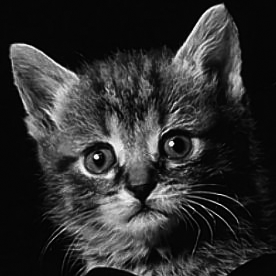

### **GIFR**

In [128]:
#拉普拉斯锐化
import numpy as np

def convolution(image, kernel):
    # 获取图像和卷积核的尺寸
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    padimage = np.pad(image,((1,1),(1,1)),mode='constant')
    # 计算卷积结果的尺寸
    result_height = image_height+2 - kernel_height + 1
    result_width = image_width+2 - kernel_width + 1

    # 创建一个与卷积结果尺寸相同的空白图像
    result = np.zeros((result_height, result_width))

    # 对图像进行卷积操作
    for i in range(result_height):
        for j in range(result_width):
            if i>0 and j>0 and i<result_height and j<result_width:
                result[i, j] = np.sum(padimage[i:i+kernel_height, j:j+kernel_width] * kernel)

    return result

# 读取图像
image = cv2.imread('./5_1_1.png',0).astype(np.float64)

# 定义卷积核
kernel = np.array([[0, 1, 0],
                   [1, -4, 1],
                   [0, 1, 0]])

# 对图像进行卷积操作
result = convolution(image, kernel)

# 打印卷积结果
#print(result)
cv2.imshow('Lap',result)
cv2.imshow('Lap',image-result)
cv2.imwrite('Lap.png',image-result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [39]:
import cv2
import numpy as np
from numpy import nonzero
import imutils

def guided_filter(in_image, guide_image, radius, epsilon):
    # 将输入图像和引导图像转换为浮点数类型
    in_image = in_image.astype(np.float64)/255
    guide_image = guide_image.astype(np.float64)/255
    
    ones=np.ones_like(guide_image)
    N = cv2.boxFilter(ones,-1, (radius, radius)); 
    # 计算均值图像和方差图像
    mean_I = cv2.boxFilter(guide_image, -1, (radius, radius))/N
    mean_p = cv2.boxFilter(in_image, -1, (radius, radius))/N
    mean_Ip = cv2.boxFilter(guide_image * in_image, -1, (radius, radius))/N
    cov_Ip = mean_Ip - mean_I * mean_p

    # 计算均值和方差
    mean_I_mean_I = cv2.boxFilter(guide_image * guide_image, -1, (radius, radius))/N
    var_I = mean_I_mean_I - mean_I * mean_I

    # 计算导向滤波系数
    a = cov_Ip / (var_I + epsilon)
    b = mean_p - a * mean_I

    # 计算均值图像和方差图像
    mean_a = cv2.boxFilter(a, -1, (radius, radius))/N
    mean_b = cv2.boxFilter(b, -1, (radius, radius))/N

    # 应用导向滤波器
    out_image = mean_a * guide_image + mean_b

    return out_image

def replaceZeroes(data):
    min_nonzero = min(data[nonzero(data)])##data中不为0数字的位置中的最小值
    data[data == 0] = min_nonzero##data中为0的位置换为最小值
    return data

def strench(image):
    MIN = np.min(image)
    MAX = np.max(image)
    #print(MIN,MAX)

    #output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image[i][j] = ((image[i][j]-MIN)/(MAX-MIN)) * 255
    return image

def guided_filter_retinex(img, guide_image,radius,epsilon):#先尝试读取引导灰度图，再分通道
    B, G, R = cv2.split(img)
    blur = guided_filter(img,guide_image,radius,epsilon)
    cv2.imwrite('BLUR.png',blur)
    G_B, G_G, G_R = cv2.split(blur)
    #blurgray = cv2.cvtColor(blur.astype(np.float32), cv2.COLOR_BGR2GRAY)#不支持双精度输入，若使用单精度效果会大打折扣

    def channel(C,G):
        #L_C = cv2.GaussianBlur(C, (0, 0), sigma)
        L_C = cv2.imread('./BLUR.png',0)
        #L_C = blurgray
        C = replaceZeroes(C)
        C = C.astype(np.float64)/255
        L_C = replaceZeroes(L_C)/255
        L_C = L_C.astype(np.float64)
        dst_C = np.log(C+1.0)
        dst_L_C = np.log(L_C+255)
        ret = cv2.subtract(dst_C, dst_L_C)
        ret = strench(ret)
        Fret = cv2.convertScaleAbs(ret)
        return Fret
    UB = channel(B,G_B)
    UG = channel(G,G_G)
    UR = channel(R,G_R)
    image = cv2.merge((UB, UG, UR))
    return image

img = cv2.imread('./5_1_1.png',1)
gud = cv2.imread('./5_1_1.png',1)#原图引导（保边滤波）
#gud = cv2.imread('./Lap.png',1)#引导图改为Laplacian锐化的图像
radius = 8
epsilon = (0.4)**2

ret = guided_filter_retinex(img,gud,radius,epsilon)


cv2.imshow("SSR",np.concatenate((img,ret),axis=1))
cv2.imshow("GFR.png",ret)
cv2.imwrite("OGFR.png",ret)
cv2.waitKey(0)
cv2.destroyAllWindows()

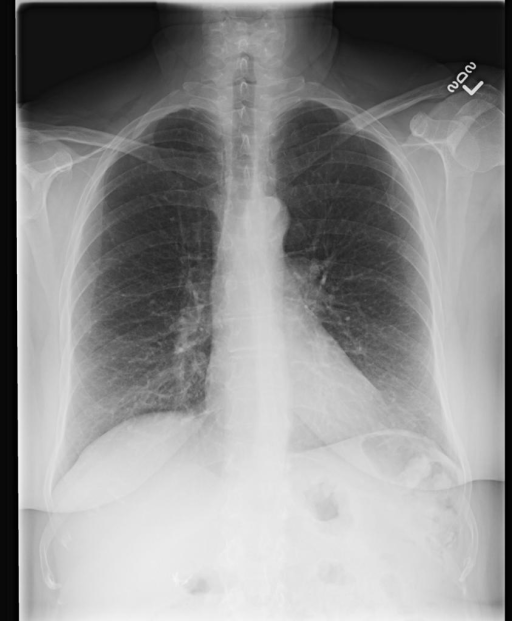

5_1_2和5_1_1是同一张图

In [108]:
def guided_filter(in_image, guide_image, radius, epsilon):
    # 将输入图像和引导图像转换为浮点数类型
    in_image = in_image.astype(np.float64)/255
    guide_image = guide_image.astype(np.float64)/255
    
    ones=np.ones_like(guide_image)
    N = cv2.boxFilter(ones,-1, (radius, radius)); 
    # 计算均值图像和方差图像
    mean_I = cv2.boxFilter(guide_image, -1, (radius, radius))/N
    mean_p = cv2.boxFilter(in_image, -1, (radius, radius))/N
    mean_Ip = cv2.boxFilter(guide_image * in_image, -1, (radius, radius))/N
    cov_Ip = mean_Ip - mean_I * mean_p

    # 计算均值和方差
    mean_I_mean_I = cv2.boxFilter(guide_image * guide_image, -1, (radius, radius))/N
    var_I = mean_I_mean_I - mean_I * mean_I

    # 计算导向滤波系数
    a = cov_Ip / (var_I + epsilon)
    b = mean_p - a * mean_I

    # 计算均值图像和方差图像
    mean_a = cv2.boxFilter(a, -1, (radius, radius))/N
    mean_b = cv2.boxFilter(b, -1, (radius, radius))/N

    # 应用导向滤波器
    out_image = mean_a * guide_image + mean_b

    return out_image

img = cv2.imread('./8_1_1.png',1)
gud = cv2.imread('./8_1_2.png',1)

blur = guided_filter(img,gud,3,0.01)
blurgray = cv2.cvtColor(blur.astype(np.float32), cv2.COLOR_BGR2GRAY)
cv2.imshow("blur",blur)
cv2.imwrite("TestGIF.png",blur)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [110]:
import cv2
import numpy as np
from numpy import nonzero

def guided_filter(in_image, guide_image, radius, epsilon):
    # 将输入图像和引导图像转换为浮点数类型
    #in_image = in_image.astype(np.float64)
    #guide_image = guide_image.astype(np.float64)
    
    ones=np.ones_like(guide_image)
    N = cv2.boxFilter(ones,-1, (radius, radius)); 
    # 计算均值图像和方差图像
    mean_I = cv2.boxFilter(guide_image, -1, (radius, radius))/N
    mean_p = cv2.boxFilter(in_image, -1, (radius, radius))/N
    mean_Ip = cv2.boxFilter(guide_image * in_image, -1, (radius, radius))/N
    cov_Ip = mean_Ip - mean_I * mean_p

    # 计算均值和方差
    mean_I_mean_I = cv2.boxFilter(guide_image * guide_image, -1, (radius, radius))/N
    var_I = mean_I_mean_I - mean_I * mean_I

    # 计算导向滤波系数
    a = cov_Ip / (var_I + epsilon)
    b = mean_p - a * mean_I

    # 计算均值图像和方差图像
    mean_a = cv2.boxFilter(a, -1, (radius, radius))/N
    mean_b = cv2.boxFilter(b, -1, (radius, radius))/N

    # 应用导向滤波器
    out_image = mean_a * guide_image + mean_b

    return out_image

def replaceZeroes(data):
    min_nonzero = min(data[nonzero(data)])##data中不为0数字的位置中的最小值
    data[data == 0] = min_nonzero##data中为0的位置换为最小值
    return data

def strench(image):
    MIN = np.min(image)
    MAX = np.max(image)
    #print(MIN,MAX)

    #output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image[i][j] = ((image[i][j]-MIN)/(MAX-MIN)) * 255
    return image

def single_scale_retinex(img, sigma):
    B, G, R = cv2.split(img)
    def channel(C):
        #L_C = cv2.GaussianBlur(C, (0, 0), sigma)
        L_C = cv2.imread('./TestGIF.png',0)
        C = replaceZeroes(C)
        C = C.astype(np.float32)/255
        L_C = replaceZeroes(L_C)
        L_C = L_C.astype(np.float32)/255
        dst_C = np.log(C+1.0)
        dst_L_C = np.log(L_C)
        ret = cv2.subtract(dst_C, dst_L_C)
        ret = strench(ret)
        Fret = cv2.convertScaleAbs(ret)
        return Fret
    UB = channel(B)
    UG = channel(G)
    UR = channel(R)
    image = cv2.merge((UB, UG, UR))
    return image

img = cv2.imread('./8_1_1.png',1)
ret = single_scale_retinex(img,300)


cv2.imshow("SSR",np.concatenate((img,ret),axis=1))
cv2.imshow("SSR.png",ret)
#cv2.imwrite("SSR.png",ret)
cv2.waitKey(0)
cv2.destroyAllWindows()

## **4.WGIFR**

### **WGIF**

In [22]:
def strench(image,normalize=True):
    """拉伸图像,线性变换至0-255

    Args:
        image (2Dnp.array): 输入的二维灰度图像
        normalize (bool, optional): 是否执行归一化. Defaults to True.

    Returns:
        2Dnp.array: 返回拉伸的图像
    """
    opreation = 1.0*image #复制一份出来，不要影响原值
    MIN = np.min(opreation)
    MAX = np.max(opreation)
    #print(MIN,MAX)
    if normalize==True:
        for i in range(opreation.shape[0]):
            for j in range(opreation.shape[1]):
                opreation[i][j] = ((opreation[i][j]-MIN)/(MAX-MIN))
    #output = np.zeros_like(image)
    if normalize==False:
        for i in range(opreation.shape[0]):
            for j in range(opreation.shape[1]):
                opreation[i][j] = ((opreation[i][j]-MIN)/(MAX-MIN)) * 255
    return opreation

def weight_guided_filter(input_image, guide_image, radius, epsilon):
    """执行WGIF运算

    Args:
        input_image (2Dnp.array): 输入的二维灰度图像
        guide_image (2Dnp.array): 输入的二维灰度引导图像
        radius (int): 滤波窗口半径
        epsilon (float): 正则化参数

    Returns:
        2Dnp.array: 返回输出的图像
    """
    # 将输入图像和引导图像转换为浮点数类型
    #input_image = input_image/255
    #guide_image = guide_image.astype(np.float64)/255

    mean_imageG = cv2.blur(guide_image, (radius, radius),borderType=cv2.BORDER_CONSTANT)

    # 计算方差图像
    padimage=np.pad(guide_image,((1,1),(1,1)),mode='constant')
    padmean=np.pad(mean_imageG,((1,1),(1,1)),mode='constant')
    variance_image = np.zeros_like(padimage)
    for i in range(padimage.shape[0]):
        for j in range(padimage.shape[1]):
            #print(i,j)
            if i>0 and j>0 and i<padimage.shape[0]-1 and j<padimage.shape[1]-1:
                #print(i,j)
                variance_image[i][j]=(1/9)*((padimage[i-1][j-1]-padmean[i][j])**2+(padimage[i-1][j]-padmean[i][j])**2+(padimage[i-1][j+1]-padmean[i][j])**2+(padimage[i][j-1]-padmean[i][j])**2+(padimage[i][j]-padmean[i][j])**2+(padimage[i][j+1]-padmean[i][j])**2+(padimage[i+1][j-1]-padmean[i][j])**2+(padimage[i+1][j]-padmean[i][j])**2+(padimage[i+1][j+1]-padmean[i][j])**2)
            if i==2 and j==2:
                print(variance_image[i][j])
    variance_image=variance_image[1:-1,1:-1]
    
    #计算权重
    Weight=np.zeros_like(variance_image)
    denominator=0
    for i in range(Weight.shape[0]):
        for j in range(Weight.shape[1]):
            denominator += 1/(variance_image[i][j]+epsilon)
    #print(denominator/(Weight.shape[0]*Weight.shape[1]))
    N = Weight.shape[0]*Weight.shape[1]
    for i in range(Weight.shape[0]):
        for j in range(Weight.shape[1]):
            Weight[i][j]=((variance_image[i][j]+epsilon)*denominator)/N
    
    SmoothWeight = cv2.GaussianBlur(Weight, (0, 0), 1.0)#来自原文：为了防止可能的阻塞伪影出现在最终图像中，ГG(p')的值被高斯滤波器平滑。
    
    Strenched=strench(SmoothWeight,True)#归一化之后是真权重，可用于后续计算，但是显示不出来，因为值很小看起来很黑
    
    StrenchedPrint = np.power(Strenched*255,1.2)#伽马变换调整一下亮暗，打印出来看一看
    cv2.imshow('SW',StrenchedPrint)
    #cv2.imwrite('Weight.png',SmoothWeight)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    #可以开始进行a_p,b_p的运算了！
    #计算输入图像的均值，注意不是引导图像
    mean_imageX = cv2.blur(input_image, (radius, radius),borderType=cv2.BORDER_CONSTANT)
    GOX=input_image * guide_image   #逐元素积
    mean_imageGOX = cv2.blur(GOX, (radius, radius),borderType=cv2.BORDER_CONSTANT)
    
    Ap = np.zeros_like(guide_image)
    for i in range(Ap.shape[0]):
        for j in range(Ap.shape[1]):
            Ap[i][j] = (mean_imageGOX[i][j]-mean_imageG[i][j]*mean_imageX[i][j])/(variance_image[i][j]+(epsilon/Strenched[i][j]))
    
    Bp = np.zeros_like(guide_image)
    for i in range(Bp.shape[0]):
        for j in range(Bp.shape[1]):
            Bp[i][j] = mean_imageX[i][j] - Ap[i][j] * mean_imageG[i][j]
    ApPrint = strench(Ap,True)
    BpPrint = strench(Bp,True)
    print('maxAp,minAp,maxBp,minBp',np.max(Ap),np.min(Ap),np.max(Bp),np.min(Bp))
    cv2.imshow('Ap',ApPrint)
    cv2.imshow('Bp',BpPrint)
    #cv2.imwrite('Weight.png',SmoothWeight)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    #最后计算变换函数！用上面的Ap和Bp进行滑窗平均得到
    meanAp = cv2.blur(Ap, (radius, radius),borderType=cv2.BORDER_CONSTANT)
    meanBp = cv2.blur(Bp, (radius, radius),borderType=cv2.BORDER_CONSTANT)
    
    #输出结果！
    output = np.zeros_like(input_image)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i][j] = meanAp[i][j] * input_image[i][j] + meanBp[i][j]
    output = strench(output,False)
    cv2.imshow('Output',output/255)
    cv2.imwrite('1644output.png',output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return output

img = cv2.imread('./5_1_1.png',0).astype(np.float64)
#img = np.array([[0,0,0,0,0],[0,2,2,2,0],[0,2,0,2,0],[0,2,2,2,0],[0,0,0,0,0]]).astype(np.float64)
gud = cv2.imread('./5_1_1.png',0).astype(np.float64)
#gud = np.array([[0,0,0,0,0],[0,2,2,2,0],[0,2,0,2,0],[0,2,2,2,0],[0,0,0,0,0]]).astype(np.float64)

weight_guided_filter(img,gud,3,(0.001*256)**2)
'''blur = weight_guided_filter(img,gud,3,0.01)
blurgray = cv2.cvtColor(blur.astype(np.float32), cv2.COLOR_BGR2GRAY)
cv2.imshow("blur",blur)
cv2.imwrite("WGIF.png",blur)
cv2.waitKey(0)
cv2.destroyAllWindows()'''

0.0


C:\Users\TYSXC\AppData\Local\Temp\ipykernel_19968\2426457919.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  Ap[i][j] = (mean_imageGOX[i][j]-mean_imageG[i][j]*mean_imageX[i][j])/(variance_image[i][j]+(epsilon/Strenched[i][j]))


maxAp,minAp,maxBp,minBp 0.9999938266593893 0.0 240.33442036274633 0.0005073829301807109


'blur = weight_guided_filter(img,gud,3,0.01)\nblurgray = cv2.cvtColor(blur.astype(np.float32), cv2.COLOR_BGR2GRAY)\ncv2.imshow("blur",blur)\ncv2.imwrite("WGIF.png",blur)\ncv2.waitKey(0)\ncv2.destroyAllWindows()'

### **WGIFR**

In [23]:
import cv2
import numpy as np
from numpy import nonzero

def replaceZeroes(data):
    min_nonzero = min(data[nonzero(data)])##data中不为0数字的位置中的最小值
    data[data == 0] = min_nonzero##data中为0的位置换为最小值
    return data

def strench(image,normalize=True):
    """拉伸图像,线性变换至0-255

    Args:
        image (2Dnp.array): 输入的二维灰度图像
        normalize (bool, optional): 是否执行归一化. Defaults to True.

    Returns:
        2Dnp.array: 返回拉伸的图像
    """
    opreation = 1.0*image #复制一份出来，不要影响原值
    MIN = np.min(opreation)
    MAX = np.max(opreation)
    #print(MIN,MAX)
    if normalize==True:
        for i in range(opreation.shape[0]):
            for j in range(opreation.shape[1]):
                opreation[i][j] = ((opreation[i][j]-MIN)/(MAX-MIN))
    #output = np.zeros_like(image)
    if normalize==False:
        for i in range(opreation.shape[0]):
            for j in range(opreation.shape[1]):
                opreation[i][j] = ((opreation[i][j]-MIN)/(MAX-MIN)) * 255
    return opreation

def single_scale_retinex(image,mask):
    def channel(C):
        ##L_C = cv2.GaussianBlur(C, (0, 0), sigma)
        L_C = mask
        
        C = replaceZeroes(C)
        C = C.astype(np.float32)/255
        print(np.max(C),np.min(C))
        L_C = replaceZeroes(L_C)
        L_C = L_C.astype(np.float32)/255
        print(np.max(L_C),np.min(L_C))
        
        cv2.imshow('L_C',L_C)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        
        dst_C = np.log(C+1.0)
        
        dst_L_C = np.log(L_C+5.0)
        #ret = np.log(C) - np.log(L_C)  # Retinex公式
        ret = cv2.subtract(dst_C, dst_L_C)
        ret = strench(ret,False)
        Fret = cv2.convertScaleAbs(ret)
        return Fret
    image = channel(image)

    return image

img = cv2.imread('./5_1_1.png',0)
mask = cv2.imread('./1644output.png',0)
#print(np.min(mask),np.max(mask))
ret = single_scale_retinex(img,mask)
#print(np.min(ret),np.max(ret))

cv2.imshow("WGIFR",np.concatenate((img,ret),axis=1))
cv2.imshow("WGIFR.png",ret)
#cv2.imwrite("SSR.png",ret)
cv2.waitKey(0)
cv2.destroyAllWindows()

0.9607843 0.003921569
1.0 0.003921569


5_1_1见上述

## **5.CWGIFR**

In [44]:
#Canny检测超参设定，确定较好的效果
gud = cv2.imread('./LUNWEN.png',0).astype(np.uint8)
gud = cv2.GaussianBlur(gud, (0, 0), 1)
variance_image = cv2.Canny(gud, threshold1=6, threshold2=20)
cv2.imshow('result',variance_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

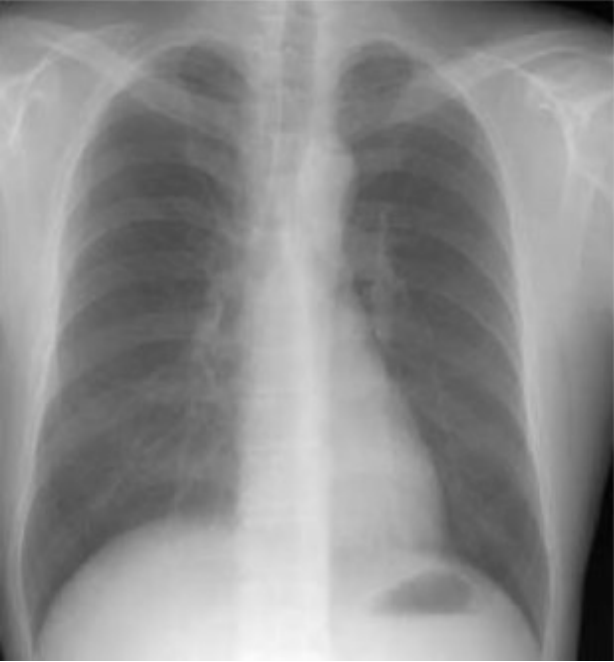

### **CWGIF**

In [56]:
def strench(image,normalize=True):
    """拉伸图像,线性变换至0-255

    Args:
        image (2Dnp.array): 输入的二维灰度图像
        normalize (bool, optional): 是否执行归一化. Defaults to True.

    Returns:
        2Dnp.array: 返回拉伸的图像
    """
    opreation = 1.0*image #复制一份出来，不要影响原值
    MIN = np.min(opreation)
    MAX = np.max(opreation)
    #print(MIN,MAX)
    if normalize==True:
        for i in range(opreation.shape[0]):
            for j in range(opreation.shape[1]):
                opreation[i][j] = ((opreation[i][j]-MIN)/(MAX-MIN))
    #output = np.zeros_like(image)
    if normalize==False:
        for i in range(opreation.shape[0]):
            for j in range(opreation.shape[1]):
                opreation[i][j] = ((opreation[i][j]-MIN)/(MAX-MIN)) * 255
    return opreation

def weight_guided_filter(input_image, guide_image, radius, epsilon):
    """执行WGIF运算

    Args:
        input_image (2Dnp.array): 输入的二维灰度图像
        guide_image (2Dnp.array): 输入的二维灰度引导图像
        radius (int): 滤波窗口半径
        epsilon (float): 正则化参数

    Returns:
        2Dnp.array: 返回输出的图像
    """
    # 将输入图像和引导图像转换为浮点数类型
    #input_image = input_image/255
    #guide_image = guide_image.astype(np.float64)/255

    mean_imageG = cv2.blur(guide_image, (radius, radius),borderType=cv2.BORDER_CONSTANT)

    # 计算方差图像
    padimage=np.pad(guide_image,((1,1),(1,1)),mode='constant')
    padmean=np.pad(mean_imageG,((1,1),(1,1)),mode='constant')
    variance_image = np.zeros_like(padimage)
    for i in range(padimage.shape[0]):
        for j in range(padimage.shape[1]):
            #print(i,j)
            if i>0 and j>0 and i<padimage.shape[0]-1 and j<padimage.shape[1]-1:
                #print(i,j)
                variance_image[i][j]=(1/9)*((padimage[i-1][j-1]-padmean[i][j])**2+(padimage[i-1][j]-padmean[i][j])**2+(padimage[i-1][j+1]-padmean[i][j])**2+(padimage[i][j-1]-padmean[i][j])**2+(padimage[i][j]-padmean[i][j])**2+(padimage[i][j+1]-padmean[i][j])**2+(padimage[i+1][j-1]-padmean[i][j])**2+(padimage[i+1][j]-padmean[i][j])**2+(padimage[i+1][j+1]-padmean[i][j])**2)
            if i==2 and j==2:
                print(variance_image[i][j])
    variance_image=variance_image[1:-1,1:-1]
    
    
    
    
    #计算权重
    Weight=np.zeros_like(variance_image)
    denominator=0
    for i in range(Weight.shape[0]):
        for j in range(Weight.shape[1]):
            denominator += 1/(variance_image[i][j]+epsilon)
    #print(denominator/(Weight.shape[0]*Weight.shape[1]))
    N = Weight.shape[0]*Weight.shape[1]
    for i in range(Weight.shape[0]):
        for j in range(Weight.shape[1]):
            Weight[i][j]=((variance_image[i][j]+epsilon)*denominator)/N
    
    SmoothWeight = cv2.GaussianBlur(Weight, (0, 0), 4.5)#来自原文：为了防止可能的阻塞伪影出现在最终图像中，ГG(p')的值被高斯滤波器平滑。
    
    gud = cv2.GaussianBlur(guide_image, (0, 0), 1).astype(np.uint8)
    #variance_image += cv2.Canny(gud, threshold1=6, threshold2=20)
    SmoothWeight += cv2.Canny(gud, threshold1=6, threshold2=20)
    
    Strenched=strench(SmoothWeight,True)#归一化之后是真权重，可用于后续计算，但是显示不出来，因为值很小看起来很黑
    
    StrenchedPrint = np.power(Strenched*255,1.2)#伽马变换调整一下亮暗，打印出来看一看
    cv2.imshow('SW',StrenchedPrint)
    #cv2.imwrite('Weight.png',SmoothWeight)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    #可以开始进行a_p,b_p的运算了！
    #计算输入图像的均值，注意不是引导图像
    mean_imageX = cv2.blur(input_image, (radius, radius),borderType=cv2.BORDER_CONSTANT)
    GOX=input_image * guide_image   #逐元素积
    mean_imageGOX = cv2.blur(GOX, (radius, radius),borderType=cv2.BORDER_CONSTANT)
    
    Ap = np.zeros_like(guide_image)
    for i in range(Ap.shape[0]):
        for j in range(Ap.shape[1]):
            Ap[i][j] = (mean_imageGOX[i][j]-mean_imageG[i][j]*mean_imageX[i][j])/(variance_image[i][j]+(epsilon/Strenched[i][j]))
    
    Bp = np.zeros_like(guide_image)
    for i in range(Bp.shape[0]):
        for j in range(Bp.shape[1]):
            Bp[i][j] = mean_imageX[i][j] - Ap[i][j] * mean_imageG[i][j]
    ApPrint = strench(Ap,True)
    BpPrint = strench(Bp,True)
    print('maxAp,minAp,maxBp,minBp',np.max(Ap),np.min(Ap),np.max(Bp),np.min(Bp))
    cv2.imshow('Ap',ApPrint)
    cv2.imshow('Bp',BpPrint)
    #cv2.imwrite('Weight.png',SmoothWeight)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    #最后计算变换函数！用上面的Ap和Bp进行滑窗平均得到
    meanAp = cv2.blur(Ap, (radius, radius),borderType=cv2.BORDER_CONSTANT)
    meanBp = cv2.blur(Bp, (radius, radius),borderType=cv2.BORDER_CONSTANT)
    
    #输出结果！
    output = np.zeros_like(input_image)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i][j] = meanAp[i][j] * input_image[i][j] + meanBp[i][j]
    output = strench(output,False)
    cv2.imshow('Output',output/255)
    cv2.imwrite('1726output.png',output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return output

img = cv2.imread('./5_1_1.png',0).astype(np.float64)
#img = np.array([[0,0,0,0,0],[0,2,2,2,0],[0,2,0,2,0],[0,2,2,2,0],[0,0,0,0,0]]).astype(np.float64)
gud = cv2.imread('./5_1_1.png',0).astype(np.float64)
#gud = np.array([[0,0,0,0,0],[0,2,2,2,0],[0,2,0,2,0],[0,2,2,2,0],[0,0,0,0,0]]).astype(np.float64)

weight_guided_filter(img,gud,3,(0.001*256)**2)
'''blur = weight_guided_filter(img,gud,3,0.01)
blurgray = cv2.cvtColor(blur.astype(np.float32), cv2.COLOR_BGR2GRAY)
cv2.imshow("blur",blur)
cv2.imwrite("WGIF.png",blur)
cv2.waitKey(0)
cv2.destroyAllWindows()'''

0.0


C:\Users\TYSXC\AppData\Local\Temp\ipykernel_19968\4235500023.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  Ap[i][j] = (mean_imageGOX[i][j]-mean_imageG[i][j]*mean_imageX[i][j])/(variance_image[i][j]+(epsilon/Strenched[i][j]))


maxAp,minAp,maxBp,minBp 0.9999907940135452 0.0 240.0 0.0007201250034114537


'blur = weight_guided_filter(img,gud,3,0.01)\nblurgray = cv2.cvtColor(blur.astype(np.float32), cv2.COLOR_BGR2GRAY)\ncv2.imshow("blur",blur)\ncv2.imwrite("WGIF.png",blur)\ncv2.waitKey(0)\ncv2.destroyAllWindows()'

### **CWGIFR**

In [57]:
import cv2
import numpy as np
from numpy import nonzero

def replaceZeroes(data):
    min_nonzero = min(data[nonzero(data)])##data中不为0数字的位置中的最小值
    data[data == 0] = min_nonzero##data中为0的位置换为最小值
    return data

def strench(image,normalize=True):
    """拉伸图像,线性变换至0-255

    Args:
        image (2Dnp.array): 输入的二维灰度图像
        normalize (bool, optional): 是否执行归一化. Defaults to True.

    Returns:
        2Dnp.array: 返回拉伸的图像
    """
    opreation = 1.0*image #复制一份出来，不要影响原值
    MIN = np.min(opreation)
    MAX = np.max(opreation)
    #print(MIN,MAX)
    if normalize==True:
        for i in range(opreation.shape[0]):
            for j in range(opreation.shape[1]):
                opreation[i][j] = ((opreation[i][j]-MIN)/(MAX-MIN))
    #output = np.zeros_like(image)
    if normalize==False:
        for i in range(opreation.shape[0]):
            for j in range(opreation.shape[1]):
                opreation[i][j] = ((opreation[i][j]-MIN)/(MAX-MIN)) * 255
    return opreation

def single_scale_retinex(image,mask):
    def channel(C):
        ##L_C = cv2.GaussianBlur(C, (0, 0), sigma)
        L_C = mask
        
        C = replaceZeroes(C)
        C = C.astype(np.float32)/255
        print(np.max(C),np.min(C))
        L_C = replaceZeroes(L_C)
        L_C = L_C.astype(np.float32)/255
        print(np.max(L_C),np.min(L_C))
        
        cv2.imshow('L_C',L_C)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        
        dst_C = np.log(C+1.0)
        
        dst_L_C = np.log(L_C+5.0)
        #ret = np.log(C) - np.log(L_C)  # Retinex公式
        ret = cv2.subtract(dst_C, dst_L_C)
        ret = strench(ret,False)
        Fret = cv2.convertScaleAbs(ret)
        return Fret
    image = channel(image)

    return image

img = cv2.imread('./5_1_1.png',0)
mask = cv2.imread('./1726output.png',0)
#print(np.min(mask),np.max(mask))
ret = single_scale_retinex(img,mask)
#print(np.min(ret),np.max(ret))

cv2.imshow("WGIFR",np.concatenate((img,ret),axis=1))
cv2.imshow("WGIFR.png",ret)
#cv2.imwrite("SSR.png",ret)
cv2.waitKey(0)
cv2.destroyAllWindows()

0.9607843 0.003921569
1.0 0.003921569


5_1_1见上述